lenth :  477
/home/gpu-machine/projects/TextSpotting/data/Test/set9_944eb0b00c1845f9b9826bfd1d2f4f67.jpg
INFO:tensorflow:Restoring parameters from /home/gpu-machine/projects/rnpd/TextSpotting/pretrained_model/rnpd_2018-07-02-09-13-31.ckpt-39999


INFO: 07-03 14:30:31: tf_logging.py:116 * 140716440168192 Restoring parameters from /home/gpu-machine/projects/rnpd/TextSpotting/pretrained_model/rnpd_2018-07-02-09-13-31.ckpt-39999
INFO: 07-03 14:30:32: <ipython-input-1-5355bd66c02f>:82 * 140716440168192 Predict image set9_944eb0b00c1845f9b9826bfd1d2f4f67.jpg label up1604


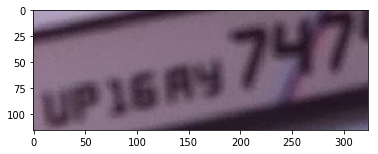

text :  up1604


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @Time    : 
# @Author  : Suresh
# @Site    : 
# @File    : demo_shadownet.py
# @IDE: PyCharm Community Edition
"""
Use shadow net to recognize the scene text
"""
import tensorflow as tf
import os.path as ops
import numpy as np
import cv2
import argparse
import matplotlib.pyplot as plt
try:
    from cv2 import cv2
except ImportError:
    pass

from crnn_model import crnn_model
from global_configuration import config
from local_utils import log_utils, data_utils

logger = log_utils.init_logger()
%matplotlib inline

def init_args():
    """
    :return:
    """
    parser = argparse.ArgumentParser()
    parser.add_argument('--image_path', type=str, help='Where you store the image',
                        default='data/Test/set9_b1a9d844a9564d74947aa3421a2d8fe5.jpg')
    parser.add_argument('--weights_path', type=str, help='Where you store the weights',
                        default='model_rnpd/rnpd_2018-07-02-09-13-31.ckpt-39999')

    return parser.parse_args()


def recognize(image_path, weights_path, is_vis=True):
    """
    :param image_path:
    :param weights_path:
    :param is_vis:
    :return:
    """
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (100, 32))
    image = np.expand_dims(image, axis=0).astype(np.float32)

    inputdata = tf.placeholder(dtype=tf.float32, shape=[1, 32, 100, 3], name='input')

    net = crnn_model.ShadowNet(phase='Test', hidden_nums=256, layers_nums=2, seq_length=25, num_classes=37)

    with tf.variable_scope('shadow'):
        net_out = net.build_shadownet(inputdata=inputdata)

    decodes, _ = tf.nn.ctc_beam_search_decoder(inputs=net_out, sequence_length=25*np.ones(1), merge_repeated=False)

    decoder = data_utils.TextFeatureIO()

    # config tf session
    sess_config = tf.ConfigProto()
    sess_config.gpu_options.per_process_gpu_memory_fraction = config.cfg.TRAIN.GPU_MEMORY_FRACTION
    sess_config.gpu_options.allow_growth = config.cfg.TRAIN.TF_ALLOW_GROWTH

    # config tf saver
    saver = tf.train.Saver()

    sess = tf.Session(config=sess_config)
    result=''
    with sess.as_default():

        saver.restore(sess=sess, save_path=weights_path)

        preds = sess.run(decodes, feed_dict={inputdata: image})

        preds = decoder.writer.sparse_tensor_to_str(preds[0])

        logger.info('Predict image {:s} label {:s}'.format(ops.split(image_path)[1], preds[0]))

#         if is_vis:
#             plt.figure('CRNN Model Demo')
#             plt.imshow(cv2.imread(image_path, cv2.IMREAD_COLOR)[:, :, (2, 1, 0)])
#             plt.show()
        result=preds[0]
        sess.close()

    return result


if __name__ == '__main__':
    import glob
#     Inti args
#     args = init_args()
#     if not ops.exists(args.image_path):
#          raise ValueError('{:s} doesn\'t exist'.format(args.image_path))

#     recognize the image
#     recognize(image_path=args.image_path, weights_path=args.weights_path)
    im_list=glob.glob("/home/gpu-machine/projects/TextSpotting/data/Test/*.jpg")
    print("lenth : ",len(im_list))
    image_path=im_list[2]
    print(image_path)
    weights_path="/home/gpu-machine/projects/rnpd/TextSpotting/pretrained_model/rnpd_2018-07-02-09-13-31.ckpt-39999"
    text=recognize(image_path=image_path, weights_path=weights_path)
    print("text : ",text)